In [216]:
%matplotlib inline

In [217]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [218]:
import numpy as np
import pandas as pd
import sklearn
import torch
import librosa
import librosa.display

In [219]:
import torchaudio
import os
import random
import matplotlib.pyplot as plt

In [220]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [201]:
# load metadata
metadata = pd.read_csv("/content/drive/MyDrive/UStest/UAV-velocity-prediction-master/information.csv")
metadata.head()

,Unnamed: 0,fname,directory,model,label
0,0,2022-05-14_06-18-26-0.wav,./dataset/big_fast_0719/,X8SW,1
1,1,2022-05-14_06-18-26-1.wav,./dataset/big_fast_0719/,X8SW,1
2,2,2022-05-14_06-18-26-2.wav,./dataset/big_fast_0719/,X8SW,1
3,3,2022-05-14_06-18-26-3.wav,./dataset/big_fast_0719/,X8SW,1
4,4,2022-05-14_06-18-26-4.wav,./dataset/big_fast_0719/,X8SW,1


In [221]:
class AudioUtil():
    def open(audio_file):
        y, sr = librosa.load(audio_file)
        return y, sr

    # data augmentation function
    def time_shift(aud, shift_limit):
        y, sr = aud
        _, sig_len = y.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return y.roll(shift_amt), sr
    
    def MFCCs(y, sr):
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        return mfccs_scaled

In [222]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

In [223]:
class CustomDataset(Dataset):
    def __init__(self, root, label):
        # file root
        self.root = root
        # slow = 0, fast = 1
        self.label = label

        fs = [os.path.join(root, f) for f in os.listdir(self.root)]
        # all file path
        self.data_files = [f for f in fs if os.path.isfile(f)]
        self.label = [label] * len(self.data_files)
    
    # __len__
    def __len__(self):
        return len(self.data_files)
    
    def __getitem__(self, idx):
        y, sr = AudioUtil.open(self.data_files[idx])
        mfcc = AudioUtil.MFCCs(y, sr)
        return mfcc, torch.tensor(self.label[idx])

In [224]:
# file path
big_fast_path = "/content/drive/MyDrive/UStest/UAV-velocity-prediction-master/dataset/big_fast"
big_slow_path = "/content/drive/MyDrive/UStest/UAV-velocity-prediction-master/dataset/big_slow"

In [206]:
slow_dataset = CustomDataset(big_slow_path, label = 0)
fast_dataset = CustomDataset(big_fast_path, label = 1)

slow_train, slow_valid, slow_test = torch.utils.data.random_split(slow_dataset,
[int(len(slow_dataset)*0.8), int(len(slow_dataset)*0.1), len(slow_dataset) - int(len(slow_dataset) * 0.8) - int(len(slow_dataset) * 0.1)],
generator=torch.Generator().manual_seed(42))

fast_train, fast_valid, fast_test = torch.utils.data.random_split(fast_dataset,
[int(len(fast_dataset)*0.8), int(len(fast_dataset)*0.1), len(fast_dataset) - int(len(fast_dataset) * 0.8) - int(len(fast_dataset) * 0.1)],
generator=torch.Generator().manual_seed(42))

In [207]:
train_dataset = torch.utils.data.ConcatDataset([slow_train, fast_train])
val_dataset = torch.utils.data.ConcatDataset([slow_valid, fast_valid])
test_dataset = torch.utils.data.ConcatDataset([slow_test, fast_test])

In [208]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

In [209]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [210]:
#JY-CNN Structure with reference to Xception Structure
class ClassifireCNN(nn.Module):
    def __init__(self, drop_out=0.0):
        super(ClassifireCNN, self).__init__()
        self.entry_flow = nn.Sequential(
            nn.Conv1d(in_channels=20, out_channels=32, kernel_size = 3, stride=2, padding=1, bias=False),

            nn.ReLU(True),
            depthwise_separable_conv(32, 32, 3, 1),

            nn.ReLU(True),
            depthwise_separable_conv(32, 8, 3, 1),
            nn.ReLU(True),
            depthwise_separable_conv(8, 1, 3, 1)
        )
        self.exit_flow_residual = nn.Conv1d(20, 1, kernel_size=1, stride=2, padding=0)
        self.cnn1 = depthwise_separable_conv(nin=20, nout=32, kernel_size=5, padding=2)
        self.cnn2 = depthwise_separable_conv(nin=32, nout=8, kernel_size=5, padding=2)
        self.cnn3 = depthwise_separable_conv(nin=8, nout= 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

        self.drop_out = nn.Dropout(p=drop_out)

    def forward(self, x):
        # input : [16, 20], [batch, feature]
        x = torch.reshape(x, (-1, 20, 1))   #[batch, feature, 1]
        x1 = self.entry_flow(x) + self.exit_flow_residual(x)
        x = torch.sigmoid(x1)

        return x.view(-1)

In [211]:
#JY-Depthwise Separable Convolution (CNN Lightweight)
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size, padding, bias=False):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv1d(nin, nin, kernel_size=kernel_size, padding=padding, groups=nin, bias=bias)
        self.pointwise = nn.Conv1d(nin, nout, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [212]:
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [213]:
LR = 0.045
PATIENCE = 3
FACTOR = 0.95
DROP_OUT = 0.3
EPOCHS = 100

In [214]:
model = ClassifireCNN(drop_out=DROP_OUT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCELoss()

In [215]:
best_auc = 0
best_epoch = -1
best_pred = []

prev_model = None

val_losses = []
train_losses = []
val_accuracy = []
train_accuracy = []

In [225]:
for i in tqdm(range(EPOCHS)):

    # Train
    loss_sum = 0
    train_loss_sum = 0
    val_loss_sum = 0
    true_labels = []
    pred_labels = []
    t_true_labels = []
    t_pred_labels = []
    v_true_labels = []
    v_pred_labels = []
    model.train()
    if i == 0:
        lr = LR
    elif i % 2 == 0 and i != 0:
        lr *= 0.94
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        
    for e_num, (x, y) in enumerate(train_loader):

        x, y = x.type(torch.FloatTensor).to(device), y.type(torch.FloatTensor).to(device)
        
        model.zero_grad()
        pred_y = model(x)

        tloss = criterion(pred_y, y)
        train_loss_sum += tloss.detach()
        
        optimizer.zero_grad()
        tloss.backward()
        optimizer.step()

        true_labels.extend(y.cpu().numpy())
        pred_labels.extend(np.around(pred_y.cpu().detach().numpy()))
        t_true_labels.extend(y.cpu().numpy())
        t_pred_labels.extend(np.around(pred_y.cpu().detach().numpy()))

    train_auc = accuracy_score(t_true_labels, t_pred_labels)
    train_accuracy.append(train_auc.item())
    auc = accuracy_score(true_labels, pred_labels)
    train_losses.append(train_loss_sum.item())

    loss_sum = train_loss_sum
    loss = tloss
    # Valid
    for e_num, (x, y) in enumerate(val_loader):
        x, y = x.type(torch.FloatTensor).to(device), y.type(torch.FloatTensor).to(device)

        pred_y = model(x)
        vloss = criterion(pred_y, y)
        loss = vloss

        val_loss_sum += vloss.detach()
        
        loss_sum += loss.detach()
        true_labels.extend(y.cpu().numpy())
        pred_labels.extend(np.around(pred_y.cpu().detach().numpy()))
        v_true_labels.extend(y.cpu().numpy())
        v_pred_labels.extend(np.around(pred_y.cpu().detach().numpy()))
        
        
    val_auc = accuracy_score(v_true_labels, v_pred_labels)
    val_accuracy.append(val_auc.item())
    auc = accuracy_score(true_labels, pred_labels)
    val_losses.append(val_loss_sum.item())

    
    
    # wirter.add_scalar("")

    if auc > best_auc:
        best_pred = pred_labels
        best_auc = auc
        best_epoch = i

        if prev_model is not None:
            os.remove(prev_model)
        prev_model = f'cnn_model_{best_auc}.h5'
        torch.save(model.state_dict(), prev_model)

    if i % 5 == 4:
      print(f"best validation acc = {best_auc}, in epoch {best_epoch}")
      print("loss = ", loss_sum)
      print("train_loss = ", train_loss_sum, "val_loss", val_loss_sum)
      print("auc = ", auc)
      print("train_auc = ", train_auc, "val_auc = ", val_auc)

print(f"best validation acc = {best_auc}, in epoch {best_epoch}")

  5%|▌         | 5/100 [07:26<2:18:14, 87.32s/it]

best validation acc = 0.9933931099575272, in epoch 1
loss =  tensor(101.1065)
train_loss =  tensor(101.1065) val_loss tensor(0.6683)
auc =  0.9797074091552619
train_auc =  0.9782493368700266 val_auc =  0.9914529914529915


 10%|█         | 10/100 [14:33<2:08:27, 85.63s/it]

best validation acc = 0.9933931099575272, in epoch 1
loss =  tensor(11.8198)
train_loss =  tensor(11.8198) val_loss tensor(0.6087)
auc =  0.9919773478055687
train_auc =  0.9915119363395225 val_auc =  0.9957264957264957


 15%|█▌        | 15/100 [21:39<2:00:52, 85.33s/it]

best validation acc = 0.9976403964134025, in epoch 14
loss =  tensor(1.5125)
train_loss =  tensor(1.5125) val_loss tensor(0.0032)
auc =  0.9976403964134025
train_auc =  0.9973474801061007 val_auc =  1.0


 20%|██        | 20/100 [28:45<1:53:18, 84.98s/it]

best validation acc = 0.9976403964134025, in epoch 14
loss =  tensor(3.6077)
train_loss =  tensor(3.6077) val_loss tensor(0.5073)
auc =  0.9966965549787635
train_auc =  0.996816976127321 val_auc =  0.9957264957264957


 25%|██▌       | 25/100 [35:55<1:47:01, 85.62s/it]

best validation acc = 0.9976403964134025, in epoch 14
loss =  tensor(9.3568)
train_loss =  tensor(9.3568) val_loss tensor(0.0017)
auc =  0.9952807928268051
train_auc =  0.9946949602122016 val_auc =  1.0


 30%|███       | 30/100 [43:10<1:41:20, 86.86s/it]

best validation acc = 0.9976403964134025, in epoch 14
loss =  tensor(40.4527)
train_loss =  tensor(40.4527) val_loss tensor(1.8162e-05)
auc =  0.9924492685228882
train_auc =  0.9915119363395225 val_auc =  1.0


 35%|███▌      | 35/100 [50:27<1:34:42, 87.43s/it]

best validation acc = 0.998112317130722, in epoch 33
loss =  tensor(9.2936)
train_loss =  tensor(9.2936) val_loss tensor(0.0489)
auc =  0.9943369513921662
train_auc =  0.9941644562334218 val_auc =  0.9957264957264957


 40%|████      | 40/100 [57:42<1:27:00, 87.01s/it]

best validation acc = 0.998112317130722, in epoch 33
loss =  tensor(16.0549)
train_loss =  tensor(16.0549) val_loss tensor(0.5436)
auc =  0.9952807928268051
train_auc =  0.9952254641909815 val_auc =  0.9957264957264957


 45%|████▌     | 45/100 [1:05:00<1:20:09, 87.45s/it]

best validation acc = 0.998112317130722, in epoch 33
loss =  tensor(3.5077)
train_loss =  tensor(3.5077) val_loss tensor(6.7801e-07)
auc =  0.996224634261444
train_auc =  0.9957559681697613 val_auc =  1.0


 50%|█████     | 50/100 [1:12:10<1:11:54, 86.29s/it]

best validation acc = 0.9985842378480415, in epoch 46
loss =  tensor(20.1897)
train_loss =  tensor(20.1897) val_loss tensor(1.0766e-06)
auc =  0.9929211892402077
train_auc =  0.9920424403183024 val_auc =  1.0


 55%|█████▌    | 55/100 [1:19:21<1:04:40, 86.24s/it]

best validation acc = 0.9985842378480415, in epoch 46
loss =  tensor(20.8027)
train_loss =  tensor(20.8027) val_loss tensor(1.4156e-07)
auc =  0.996224634261444
train_auc =  0.9957559681697613 val_auc =  1.0


 60%|██████    | 60/100 [1:26:30<57:13, 85.83s/it]

best validation acc = 0.9985842378480415, in epoch 46
loss =  tensor(3.3397)
train_loss =  tensor(3.3397) val_loss tensor(0.3160)
auc =  0.9976403964134025
train_auc =  0.9978779840848806 val_auc =  0.9957264957264957


 65%|██████▌   | 65/100 [1:33:40<50:04, 85.85s/it]

best validation acc = 0.999056158565361, in epoch 64
loss =  tensor(1.0504)
train_loss =  tensor(1.0504) val_loss tensor(0.0005)
auc =  0.999056158565361
train_auc =  0.9989389920424403 val_auc =  1.0


 70%|███████   | 70/100 [1:40:49<42:51, 85.71s/it]

best validation acc = 0.999056158565361, in epoch 64
loss =  tensor(9.5292)
train_loss =  tensor(9.5292) val_loss tensor(0.0090)
auc =  0.9966965549787635
train_auc =  0.9962864721485412 val_auc =  1.0


 75%|███████▌  | 75/100 [1:48:01<35:56, 86.28s/it]

best validation acc = 0.999056158565361, in epoch 64
loss =  tensor(25.2502)
train_loss =  tensor(25.2502) val_loss tensor(0.)
auc =  0.9948088721094857
train_auc =  0.9941644562334218 val_auc =  1.0


 80%|████████  | 80/100 [1:55:11<28:41, 86.09s/it]

best validation acc = 0.9995280792826805, in epoch 75
loss =  tensor(5.2880)
train_loss =  tensor(5.2880) val_loss tensor(0.2909)
auc =  0.9957527135441245
train_auc =  0.9957559681697613 val_auc =  0.9957264957264957


 85%|████████▌ | 85/100 [2:02:18<21:25, 85.68s/it]

best validation acc = 0.9995280792826805, in epoch 75
loss =  tensor(3.4252)
train_loss =  tensor(3.4252) val_loss tensor(0.0662)
auc =  0.9966965549787635
train_auc =  0.996816976127321 val_auc =  0.9957264957264957


 90%|█████████ | 90/100 [2:09:27<14:18, 85.80s/it]

best validation acc = 0.9995280792826805, in epoch 75
loss =  tensor(2.5154)
train_loss =  tensor(2.5154) val_loss tensor(0.)
auc =  0.997168475696083
train_auc =  0.996816976127321 val_auc =  1.0


 95%|█████████▌| 95/100 [2:16:37<07:10, 86.07s/it]

best validation acc = 0.9995280792826805, in epoch 75
loss =  tensor(15.8642)
train_loss =  tensor(15.8642) val_loss tensor(4.4703e-08)
auc =  0.9948088721094857
train_auc =  0.9941644562334218 val_auc =  1.0


100%|██████████| 100/100 [2:23:47<00:00, 86.27s/it]

best validation acc = 0.9995280792826805, in epoch 75
loss =  tensor(5.0125)
train_loss =  tensor(5.0125) val_loss tensor(0.0002)
auc =  0.9966965549787635
train_auc =  0.9962864721485412 val_auc =  1.0
best validation acc = 0.9995280792826805, in epoch 75


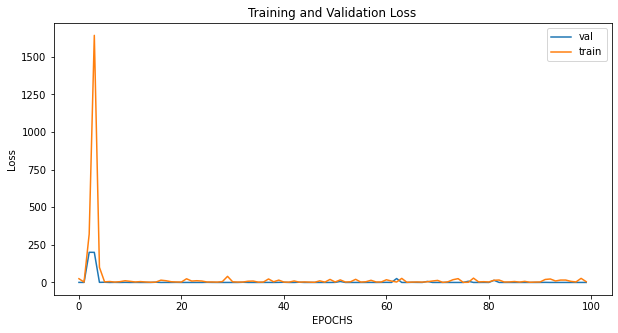

In [226]:
#JY-loss graph
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("EPOCHS")
plt.ylabel("Loss")
plt.legend()
plt.show()

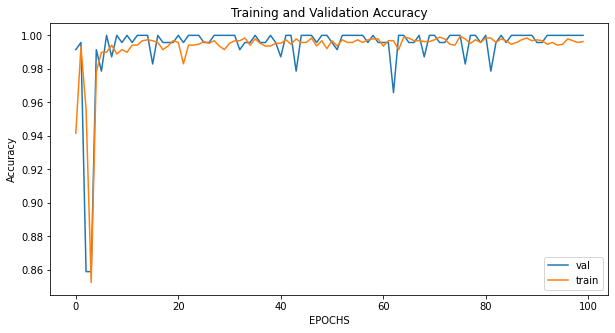

In [227]:
#JY-Accuracy graph
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracy,label="val")
plt.plot(train_accuracy,label="train")
plt.xlabel("EPOCHS")
plt.ylabel("Accuracy")
plt.legend()
plt.show()